In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time
from pathlib import Path
from tqdm import tqdm

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
mnist = datasets.FashionMNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [3]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [4]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)

### Model Development

In [5]:
def generate_dimension_encoding(dim, binarize=True):
    num_d = int(np.ceil(np.log2(dim)))
#     print(num_d)
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
#     pos = np.unpackbits(indx.astype()).reshape(-1,8)
    ### target matrix shape is dim, num_d
#     ax = 1/np.arange(0, dim, 1).reshape(-1,1) * scale
#     print(indx_mat.shape)
    mat = index*scale
#     print(1/mat)
#     print(np.sin(mat)**2)
#     pos_mat = np.sin(mat*np.pi/2)**2
#     return torch.Tensor(pos_mat)
    
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)**2
    cos_mat = np.cos(mat)**2
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
#     print(pos_mat.shape)
    return torch.Tensor(pos_mat)



def generate_dimension_encoding2(dim):
    num_d = int(np.ceil(np.log2(dim)))
    pos_mat = np.empty((dim, num_d))
    for i in range(dim):
        binary = np.binary_repr(i, width=num_d)
        pos_mat[i] = [float(a) for a in binary]
    
    pos_mat = np.concatenate((pos_mat, 1-pos_mat), axis=1)
    return torch.Tensor(pos_mat)


class Layer_DimEncMLP_mul(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
#         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
#         print(la_dims)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
#         print(layers)
        layers[-1].weight.data *= 0.
        self.net = nn.Sequential(*layers)
        
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)

#         bs, dim = x.shape
        num_d = self.pos_mat.shape[1]
        encodedX = (x.unsqueeze(dim=2)*self.pos_mat.unsqueeze(dim=0))
#         print(encodedX.shape)
        y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         print(y.shape)
        return y


class Layer_DimEncMLP_cat(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim+1]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
        self.net = nn.Sequential(*layers)
        
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)
        
        num_d = self.pos_mat.shape[1]
        encodedX = torch.cat([\
                              x.unsqueeze(dim=2),\
                              self.pos_mat.expand(x.shape[0], *self.pos_mat.shape)\
                             ],\
                             dim=2)
        y = self.net(encodedX.reshape(-1, num_d+1)).reshape(x.shape)
        return y
    
    
class Layer_DimEncMLP_add(nn.Module):
    def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        
        self.pos_mat = generate_dimension_encoding(dim)
#         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
        self.pos_mat = self.pos_mat*2-1
        mlp_inp_dim = self.pos_mat.shape[1]
        la_dims = [mlp_inp_dim]
        for hr in hidden_ratio:
            la_dims.append(int(hr*mlp_inp_dim))
        la_dims.append(1)
        
#         print(la_dims)
        
        layers = []
        for i in range(len(la_dims)-1):
            _a = nn.Linear(la_dims[i], la_dims[i+1])
            layers += [_a, activation]
        layers = layers[:-1]
#         print(layers)
        self.net = nn.Sequential(*layers)
        self.pos_mat = nn.Parameter(self.pos_mat)
    
#         self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
#         x = self.norm(x)

#         bs, dim = x.shape
        num_d = self.pos_mat.shape[1]
        encodedX = (x.unsqueeze(dim=2)+self.pos_mat.unsqueeze(dim=0))
#         print(encodedX.shape)
        y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         print(y.shape)
        return y

In [6]:
# np.ones((3, 1))
# [float(a) for a in np.binary_repr(3, width=5)]

In [7]:
X = torch.randn(2,7)
pos_mat = generate_dimension_encoding2(7)
pos_mat

tensor([[0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.]])

In [8]:
pos_mat.expand(X.numel(), *pos_mat.shape).shape

torch.Size([14, 7, 6])

In [9]:
X.numel(), pos_mat.shape[1]

(14, 6)

In [10]:
print(X.unsqueeze(dim=2).shape, pos_mat.unsqueeze(dim=0).shape)

torch.Size([2, 7, 1]) torch.Size([1, 7, 6])


In [11]:
# posExp = pos_mat.expand(X.shape[0], *pos_mat.shape)
torch.cat([X.unsqueeze(dim=2), pos_mat.expand(X.shape[0], *pos_mat.shape)],
          dim=2)

tensor([[[ 1.3655,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000],
         [-0.9856,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
         [ 0.4437,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.3382,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000],
         [ 0.5879,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000],
         [ 0.2008,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
         [ 0.0814,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.3315,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000],
         [-1.9682,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
         [ 0.4467,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [-1.2560,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000],
         [ 1.1663,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000],
         [-1.2461,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
         [-0.3450,  1.0000,  1.0000,

In [12]:
# plt.plot(pos_mat[:, :pos_mat.shape[1]//2])

In [13]:
# plt.plot(pos_mat[:, pos_mat.shape[1]//2:])

In [14]:
# net = Layer_DimEncMLP(784)
# X = torch.randn(2,784)

In [15]:
# net.net

In [16]:
# net(X).shape

In [17]:
# class MLP_0(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.l1 = nn.Linear(784, 300)
#         self.l2 = Layer_DimEncMLP(300, [5, 5])
#         self.l3 = nn.Linear(300, 10)
        
#     def forward(self, x):
#         x = self.l1(x)
#         res = self.l2(x)
#         x = x+res
#         x = self.l3(x)
#         return x

In [18]:
class MLP_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 300)
        self.l2 = nn.LeakyReLU()
        self.l3 = nn.Linear(300, 100)
        self.l4 = nn.LeakyReLU()
        self.l5 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x
    
class MLP_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 300)
#         self.l3 = nn.Linear(300, 100)
        self.l5 = nn.Linear(300, 10)
        self.l2 = Layer_DimEncMLP_cat(300, [5,5], activation=nn.SiLU())
#         self.l2.net[-1].weight.data *= 0
#         self.l4 = Layer_DimEncMLP_cat(100, [3], activation=nn.ELU())
#         self.l4.net[-1].weight.data *= 0
        
    def forward(self, x):
        x = self.l1(x)
        res = self.l2(x)
        x = x+res
#         x = res
#         x = self.l3(x)
#         res = self.l4(x)
#         x = x+res
        x = self.l5(x)
        return x
    


In [19]:
X = torch.randn(2,784)

In [20]:
MLP_1()(X).shape

torch.Size([2, 10])

In [21]:
# K=2
# np.sin(((1/2)**np.arange(0, 6))*np.pi/2)

In [22]:
# encodedX

### Model Training

In [23]:
torch.manual_seed(0)
# model = MLP_0()
model = MLP_1()
model

MLP_1(
  (l1): Linear(in_features=784, out_features=300, bias=True)
  (l5): Linear(in_features=300, out_features=10, bias=True)
  (l2): Layer_DimEncMLP_cat(
    (net): Sequential(
      (0): Linear(in_features=19, out_features=90, bias=True)
      (1): SiLU()
      (2): Linear(in_features=90, out_features=90, bias=True)
      (3): SiLU()
      (4): Linear(in_features=90, out_features=1, bias=True)
    )
  )
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
## small: 242561 on MLP_0 -> 97.5    || 238510 on MLP_1 -> 97.06
## big: 275140 on MLP_0 -> 97.74   || 266610 on MLP_1 -> 97.5
## FMNIST
## 
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  253991


In [ ]:
EPOCHS = 15
steps_ = 0
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    for index in range(train_size // batch_size):
        steps_ += 1

        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]

        yout = model(train_x)
        loss = criterion(yout, train_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
        train_acc += (outputs == train_y.data.cpu().numpy()).sum()
        train_count += len(outputs)

        if steps_%500==0:
            train_accuracy = train_acc/train_count
            train_acc, train_count = 0, 0
            
            print(f'\nEpoch: {epoch}, batch: {index}, step: {steps_}, loss: {float(loss)}')
            print(f'\tTrain acc: {train_accuracy*100}%')
            
            with torch.no_grad():
                test_acc, test_count = 0, 0
                model.eval()
                for _ti in range(len(test_data) // batch_size):
                    test_x = test_data[_ti * batch_size:(_ti + 1) * batch_size]
                    test_y_ = test_label_[_ti * batch_size:(_ti + 1) * batch_size]
                    yout = model(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
                    correct = (outputs == test_y_).sum()
                    test_acc += correct
                    test_count += len(test_x)
                model.train()

            print(f'\tTest acc: {test_acc/test_count*100}%, correct: {test_acc}/{test_count}')


Epoch: 0, batch: 499, step: 500, loss: 0.31257498264312744
	Train acc: 89.376%
	Test acc: 86.92999999999999%, correct: 8693/10000

Epoch: 0, batch: 999, step: 1000, loss: 0.44746237993240356
	Train acc: 90.228%
	Test acc: 87.56%, correct: 8756/10000

Epoch: 1, batch: 299, step: 1500, loss: 0.41474586725234985
	Train acc: 89.87333333333333%
	Test acc: 87.1%, correct: 8710/10000

Epoch: 1, batch: 799, step: 2000, loss: 0.2596442699432373
	Train acc: 90.488%
	Test acc: 87.15%, correct: 8715/10000

Epoch: 2, batch: 99, step: 2500, loss: 0.18409320712089539
	Train acc: 90.42%
	Test acc: 87.94999999999999%, correct: 8795/10000

Epoch: 2, batch: 599, step: 3000, loss: 0.21561460196971893
	Train acc: 90.652%
	Test acc: 87.59%, correct: 8759/10000

Epoch: 2, batch: 1099, step: 3500, loss: 0.3788411021232605
	Train acc: 91.16%
	Test acc: 87.88%, correct: 8788/10000

Epoch: 3, batch: 399, step: 4000, loss: 0.2731572985649109
	Train acc: 91.01%
	Test acc: 87.83%, correct: 8783/10000

Epoch: 3, ba

In [27]:
len(test_data)//batch_size

200

In [28]:
### number of params:  267780, 267920
## MLP_1, sin_encoding: train,test = 95.0, 88.35 at max
## MLP_1, binary_encod: train,test = 93.5, 88.37 at max
### number of params:  267844
## MLP_1, sin, cat: train,test = 88.19, 86.38 at max ;; 94.24, 88.93 | double trained
## MLP_1, sin, add: train,test = 95.7, 88.51


### number of params:  266610
## MLP_0, LeakyRelu: train,test = 89.6, 87.27 at max ;; 92.13, 88.59 | double trained

## Visualize first activations

In [29]:
### inputs from -1, 1 for every dimension in a batch
X = torch.linspace(-1, 1, steps=20).expand(300, -1).transpose(0,1)
X.shape

torch.Size([20, 300])

In [30]:
model.eval()
ys = model.l2(X).data.cpu()
ys.shape

torch.Size([20, 300])

In [31]:
ys[0]

tensor([-12.5439, -10.8277, -13.2656, -12.6980, -15.1710, -12.4673, -12.8762,
        -10.7758, -12.2546, -10.4596, -12.0168, -11.6183, -13.9182, -11.3380,
        -11.6934,  -9.3559, -10.6604,  -9.3972, -11.6281, -11.2066, -13.7831,
        -11.8086, -12.5629, -10.8152, -12.6767, -11.2542, -13.5316, -12.8266,
        -15.3558, -12.8124, -13.3933, -11.2654, -12.9434, -11.5508, -13.6839,
        -13.4130, -15.5274, -13.3274, -13.8861, -11.7993, -13.1612, -11.4377,
        -13.0052, -12.7642, -15.1831, -12.4573, -12.8509, -10.0280, -11.7879,
        -10.4079, -13.0788, -12.8440, -15.6322, -13.2292, -14.1983, -12.2716,
        -13.9728, -12.7164, -15.0583, -14.7511, -17.4436, -14.4335, -15.2082,
        -12.6499, -14.5076, -12.5888, -15.4413, -14.4285, -17.2800, -14.8055,
        -15.0009, -12.7841, -14.1879, -11.9770, -14.0963, -13.0105, -15.6312,
        -12.7518, -13.5193, -10.2779, -12.4077, -10.6866, -12.8410, -12.7480,
        -15.4225, -12.8275, -13.6318, -11.8857, -13.2697, -12.38

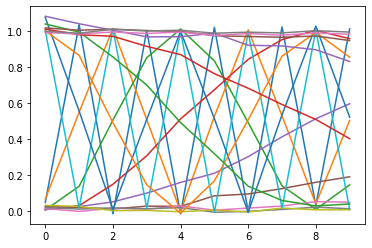

In [32]:
%matplotlib inline
plt.plot(model.l2.pos_mat.data[:10])

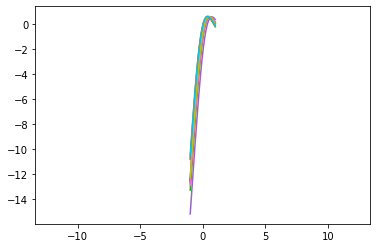

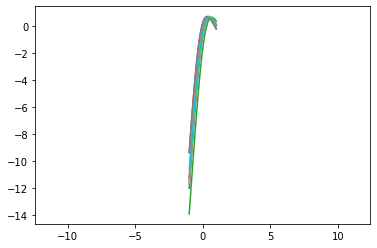

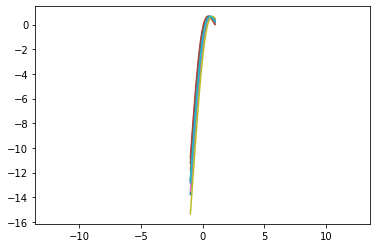

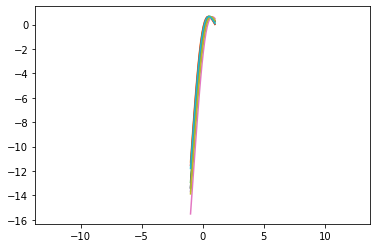

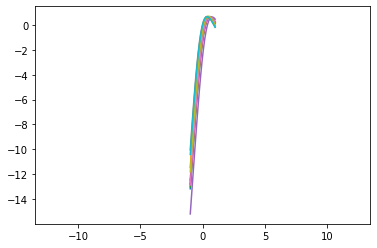

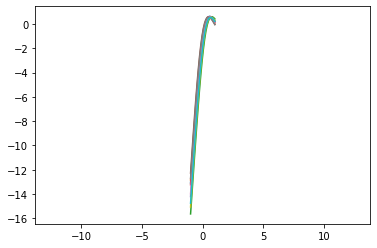

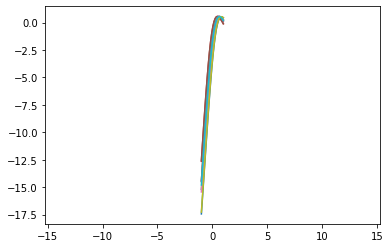

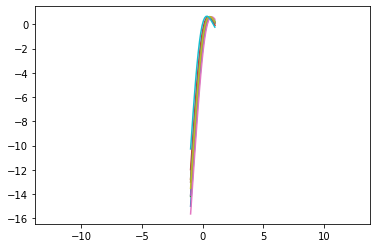

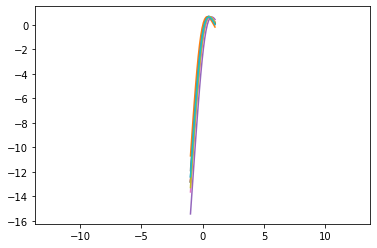

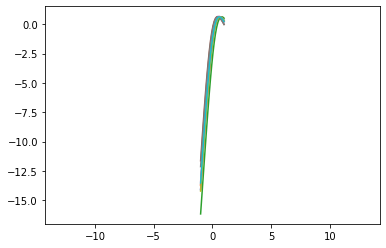

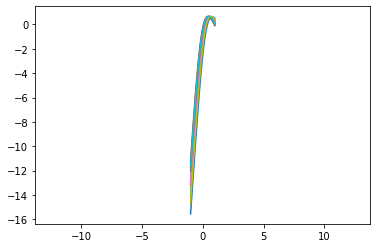

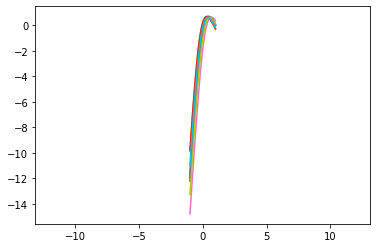

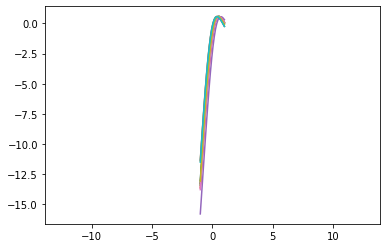

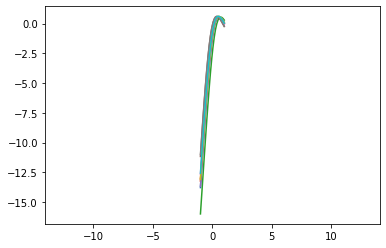

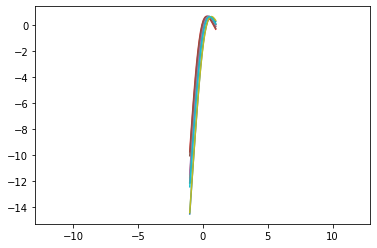

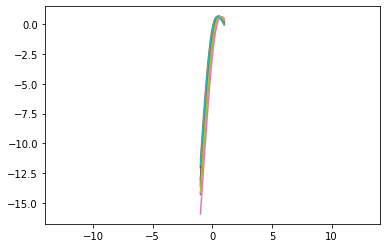

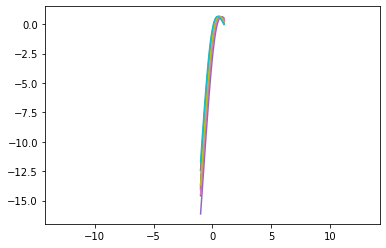

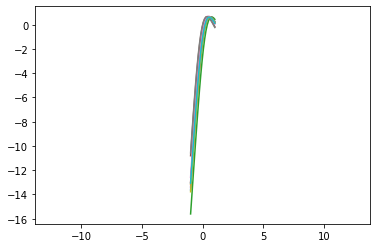

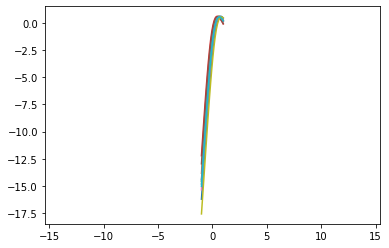

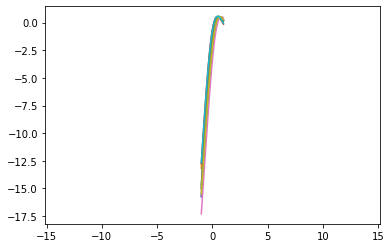

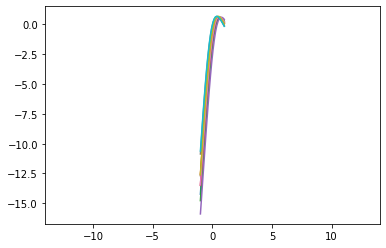

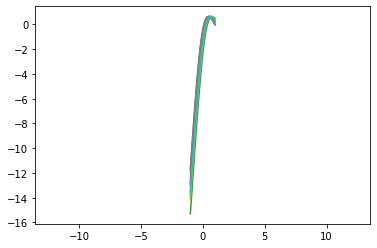

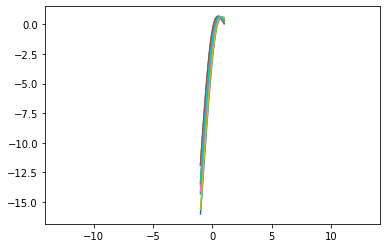

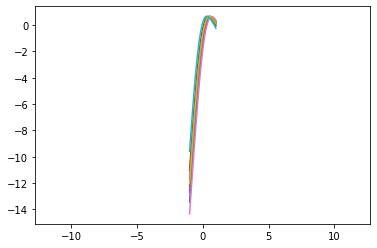

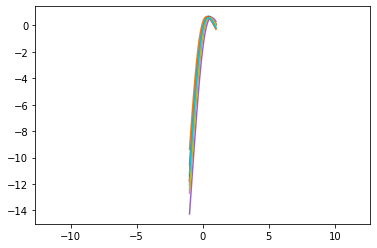

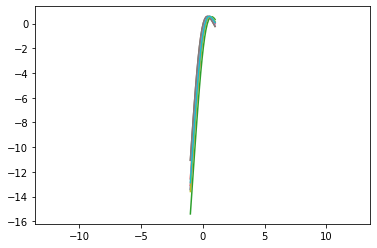

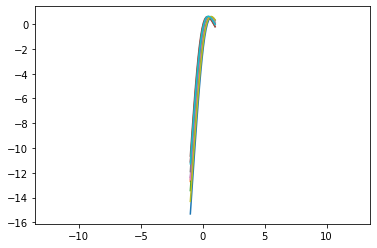

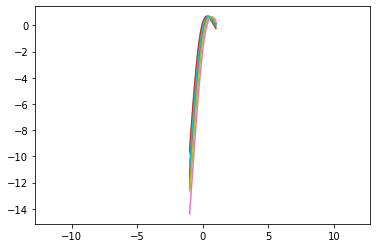

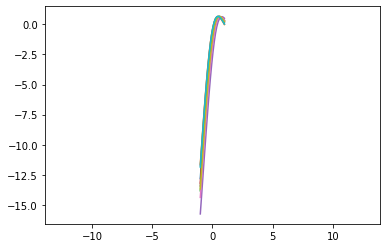

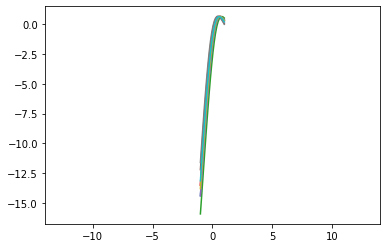

In [33]:
num_show = 10
for i in range(300):
    plt.plot(X[:,i], ys[:,i])#+X[:,i])
    if (i+1)%num_show == 0:
        plt.axis("equal")
        plt.show()

In [34]:
# model = MLP_1()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("number of params: ", sum(p.numel() for p in model.parameters()))

In [35]:
# EPOCHS = 15
# steps_ = 0
# for epoch in range(EPOCHS):
#     train_acc = 0
#     train_count = 0
#     for index in range(train_size // batch_size):
#         steps_ += 1

#         train_x = train_data[index * batch_size:(index + 1) * batch_size]
#         train_y = train_label[index * batch_size:(index + 1) * batch_size]

#         yout = model(train_x)
#         loss = criterion(yout, train_y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if steps_%500==0:
#             print('\nTRAIN',epoch, steps_, '-> ', float(loss))
# #             yout = model.forward(train_data)
# #             outputs = tnn.Logits.logit_to_index(yout)
# #             correct = (outputs == np.array(train_label_)).sum()

# #             accuracy = correct / len(train_label_) * 100.
# #             print('EPOCH = ','accuracy = ', accuracy)
# #             print(correct, '/', len(train_label_))
            
#             with torch.no_grad():
#                 yout = model(test_data)
#             outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
#             correct = (outputs == np.array(test_label_)).sum()

#             accuracy = correct / len(test_label_) * 100.
#             print('   TEST  ','accuracy = ', accuracy)
#             print(correct, '/', len(test_label_))       

In [36]:
# model.l2.pos_mat

In [37]:
np.log2(128)

7.0